In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from scipy import stats

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
58400,00014438_002.png,No Finding,2,14438,54,F,PA,2992,2991,0.143,0.143,NaN
43893,00011322_004.png,Cardiomegaly,4,11322,36,F,PA,2482,2991,0.143,0.143,NaN
17069,00004578_001.png,Atelectasis|Infiltration,1,4578,54,F,AP,2500,2048,0.168,0.168,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2241,00011523_000.png,No Finding,0,11523,042Y,F,PA,2992,2991,0.143,0.143
4083,00020149_000.png,No Finding,0,20149,061Y,M,PA,2500,2048,0.168,0.168
3270,00016134_002.png,No Finding,2,16134,043Y,M,AP,2500,2048,0.168,0.168


In [5]:
# The number of cases including: number of pneumonia cases, number of non-pneumonia cases
total_cases = len(all_xray_df.index)

# Split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag.

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
26118,00006851_028.png,Infiltration,28,6851,45,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
76730,00018856_001.png,No Finding,1,18856,44,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1418,00000370_009.png,No Finding,9,370,61,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


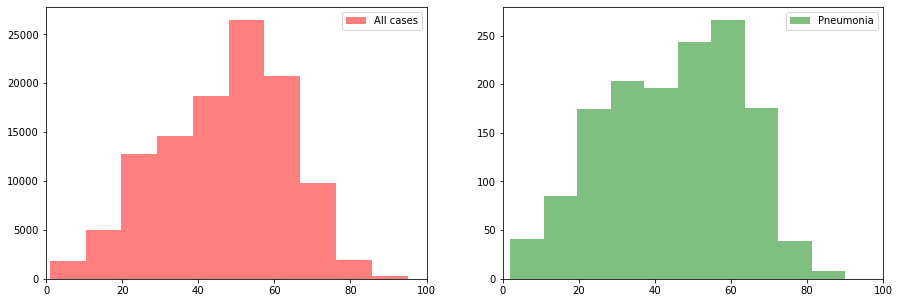

In [29]:
## EDA
# The patient demographic data such as gender, age, patient position,etc. (as it is available)
# age: The data is not clean, as there are patients over 400yo, I will remove any over 100 since they are all absurd (148+)
all_xray_df = all_xray_df[all_xray_df['Patient Age']<100]

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(all_xray_df['Patient Age'], bins=10, alpha = 0.5, color = 'r', label='All cases')
ax[0].set_xlim([0, 100])
ax[1].hist(all_xray_df[all_xray_df['Pneumonia']==1]['Patient Age'], bins=10, alpha = 0.5, color = 'g', label='Pneumonia')
ax[1].set_xlim([0, 100])
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
plt.show()

Looking at the age distribution, we might want to target 20 to 70 yo patients. It seems that patients with pneumonia are a bit older than the average.

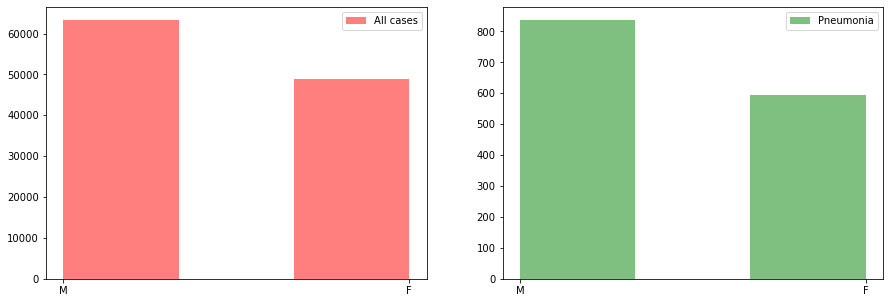

In [27]:
# gender:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(all_xray_df['Patient Gender'], bins=3, alpha = 0.5, color = 'r', label='All cases')
ax[1].hist(all_xray_df[all_xray_df['Pneumonia']==1]['Patient Gender'], bins=3, alpha = 0.5, color = 'g', label='Pneumonia')
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
plt.show()

The gender distribution looks rather balanced, so we can target both men and women

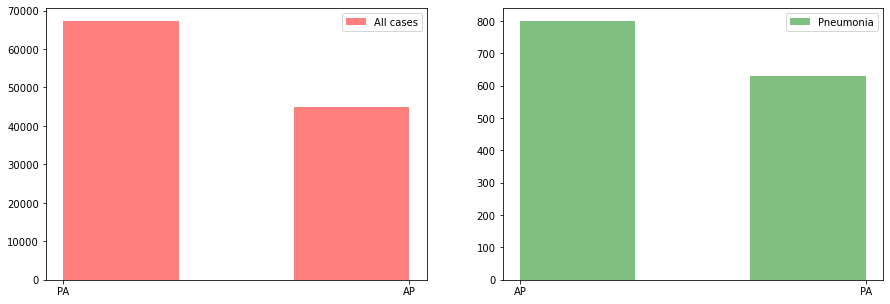

In [28]:
# The x-ray views taken (i.e. view position)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(all_xray_df['View Position'], bins=3, alpha = 0.5, color = 'r', label='All cases')
ax[1].hist(all_xray_df[all_xray_df['Pneumonia']==1]['View Position'], bins=3, alpha = 0.5, color = 'g', label='Pneumonia')
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
plt.show()

The view position might be a big factor in the algorithm's output. If we find this to be true, we might only use PA positions in the training and validation dataset.

In [11]:
nb_positive_cases = all_xray_df['Pneumonia'].sum()  # nb of positive cases for Pneumonia
nb_negative_cases = total_cases - nb_positive_cases
nb_positive_cases, nb_negative_cases

# There are 1430 positive cases and 110674 negative cases for Pneumonia

(1431.0, 110689.0)

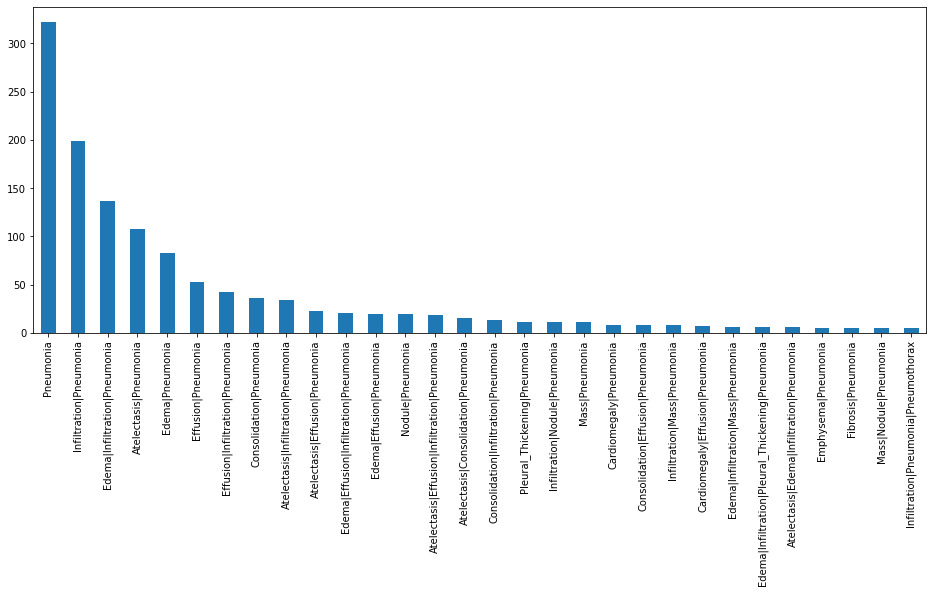

In [10]:
# The distribution of other diseases that are comorbid with pneumonia
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Pneumonia often appears with other comorbodities, particularly with Infiltration, Atelectasis and Edema.

In [12]:
# Number of disease per patient. I'm guessing distinct diseases per patient
disease_labels = [x for x in all_labels if x not in ['No Finding']]  # all_labels - 'No Finding'
df_dict = {}
df_dict['Patient ID'] = np.unique(all_xray_df['Patient ID'])
df_dict['Number of diseases'] = []
for patient_id in df_dict['Patient ID']:
    # how many occurences of each disease for each patient
    sum_list = [all_xray_df[all_xray_df['Patient ID']==patient_id][disease].sum() for disease in disease_labels]
    # how many unique diseases for each patient
    df_dict['Number of diseases'] += [sum(x > 0 for x in sum_list)]
disease_df = pd.DataFrame(df_dict)

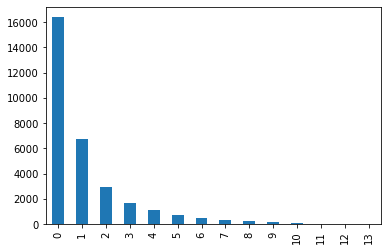

In [18]:
# distribution of number of diseases per patient
disease_df['Number of diseases'].value_counts().plot(kind='bar')

In [17]:
# average number of diseases per patient
disease_df['Number of diseases'].mean()

1.1355756119732485

Most patients do not show sign of a disease and the average only present one unique disease in all of their images.

In [4]:
# Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values)
# and compare distributions across diseases.
# Split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag.

all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3884,00019133_000.png,No Finding,0,19133,044Y,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1240,00006519_026.png,Atelectasis|Effusion|Infiltration,26,6519,059Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
185,00001075_003.png,Mass|Pleural_Thickening,3,1075,059Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to sample_df
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df[sample_df['Pneumonia']==1].sample(10)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
2808,00014004_012.png,Edema|Pneumonia,12,14004,058Y,F,AP,2916,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_007/images/00014004_012.png
256,00001373_010.png,Cardiomegaly|Effusion|Pneumonia,10,1373,058Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_002/images/00001373_010.png
4618,00023089_004.png,Infiltration|Pneumonia,4,23089,059Y,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_010/images/00023089_004.png
5366,00028924_005.png,Pneumonia,5,28924,072Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_012/images/00028924_005.png
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_008/images/00017714_019.png
4966,00026179_003.png,Pneumonia,3,26179,026Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_011/images/00026179_003.png
1078,00005681_018.png,Emphysema|Pneumonia,18,5681,046Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_003/images/00005681_018.png
1683,00008763_001.png,Nodule|Pneumonia,1,8763,061Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,/data/images_004/images/00008763_001.png
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,/data/images_002/images/00001993_000.png
5168,00027589_001.png,Effusion|Pneumonia,1,27589,014Y,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/data/images_011/images/00027589_001.png


In [6]:
pa_healthy = plt.imread('/data/images_012/images/00028661_006.png')
pa_pneumonia = plt.imread('/data/images_004/images/00008763_001.png')
ap_healthy = plt.imread('/data/images_003/images/00004342_008.png')
ap_pneumonia = plt.imread('/data/images_010/images/00021289_000.png')

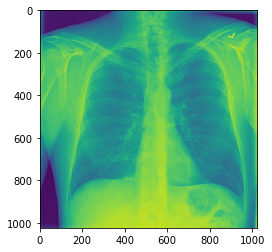

In [9]:
# Show a healthy PA image
plt.imshow(pa_healthy)

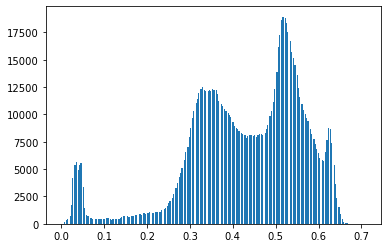

In [10]:
x = plt.hist(pa_healthy.ravel(),bins=256)

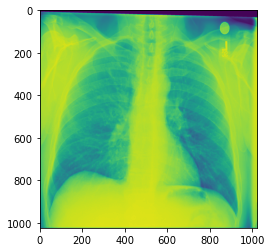

In [10]:
# Show a diseased PA image
plt.imshow(pa_pneumonia)

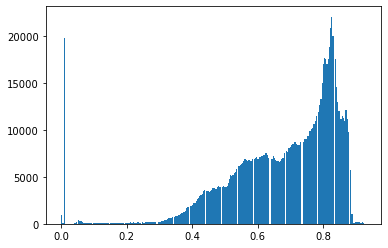

In [9]:
x = plt.hist(pa_pneumonia.ravel(),bins=256)

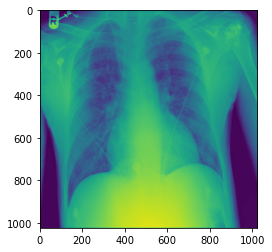

In [11]:
# Show a healthy AP image
plt.imshow(ap_healthy)

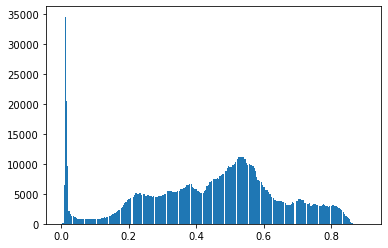

In [8]:
x = plt.hist(ap_healthy.ravel(),bins=256)

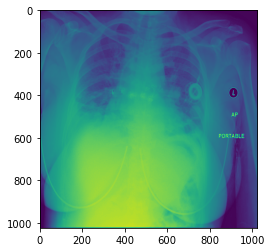

In [13]:
# Show a diseased AP image
plt.imshow(ap_pneumonia)

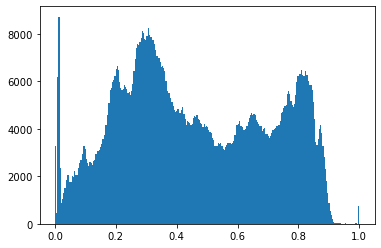

In [7]:
x = plt.hist(ap_pneumonia.ravel(),bins=256)

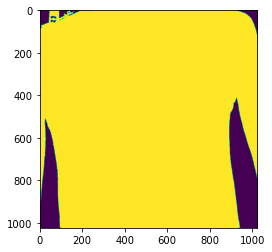

In [7]:
# Let's use a treshold to better compare the densities. 0.1 seems to be good for background-removing
thresh = 0.1

ap_healthy_bin = (ap_healthy > thresh)

plt.imshow(ap_healthy_bin)

In [8]:
sample_df_pa = sample_df[sample_df['View Position']=='PA']
sample_df_ap = sample_df[sample_df['View Position']=='AP']

pneumonia_ap_intensities = []
pneumonia_pa_intensities = []

for i in sample_df_pa[sample_df_pa['Pneumonia']==1]['path']: 
    img = plt.imread(i)
    img_mask = (img > thresh)
    pneumonia_pa_intensities.extend(img[img_mask].tolist())

for i in sample_df_ap[sample_df_ap['Pneumonia']==1]['path']: 
    img = plt.imread(i)
    img_mask = (img > thresh)
    pneumonia_ap_intensities.extend(img[img_mask].tolist())

In [9]:
healthy_ap_intensities = []
healthy_pa_intensities = []

# the dataset of healthy (No finding) patients is too big to be computed quickly, I'll use a sample:
sample_pa_healthy = sample_df_pa[sample_df_pa['No Finding']==1]['path'].sample(100)
sample_ap_healthy = sample_df_ap[sample_df_ap['No Finding']==1]['path'].sample(100)

for i in sample_pa_healthy: 
    img = plt.imread(i)
    img_mask = (img > thresh)
    healthy_pa_intensities.extend(img[img_mask].tolist())

for i in sample_ap_healthy:
    img = plt.imread(i)
    img_mask = (img > thresh)
    healthy_ap_intensities.extend(img[img_mask].tolist())

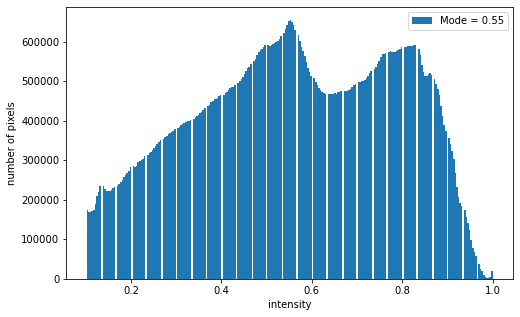

In [10]:
plt.figure(figsize=(8,5))
plt.hist(healthy_pa_intensities,bins=256)
mode = stats.mode(healthy_pa_intensities)
plt.legend(['Mode = %.2f' % mode[0]])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

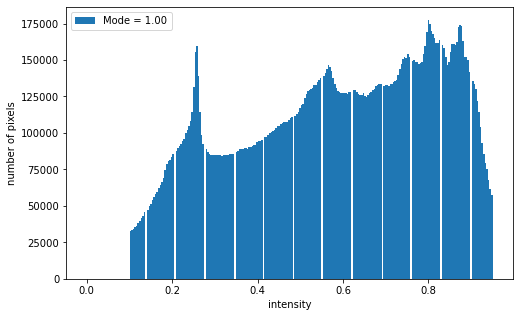

In [11]:
# I cut this histogram at 0.95 because of a massive peak that looks like noise
plt.figure(figsize=(8,5))
plt.hist(pneumonia_pa_intensities,bins=256,range=(0, 0.95))
mode = stats.mode(pneumonia_pa_intensities)
plt.legend(['Mode = %.2f' % mode[0]])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

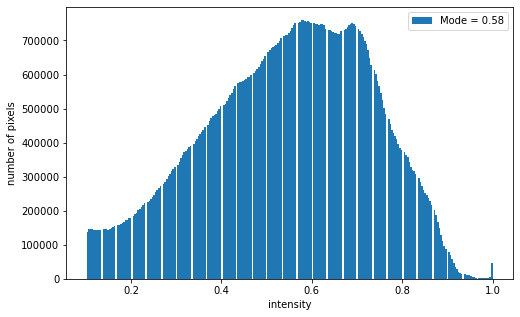

In [12]:
plt.figure(figsize=(8,5))
plt.hist(healthy_ap_intensities,bins=256)
mode = stats.mode(healthy_ap_intensities)
plt.legend(['Mode = %.2f' % mode[0]])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

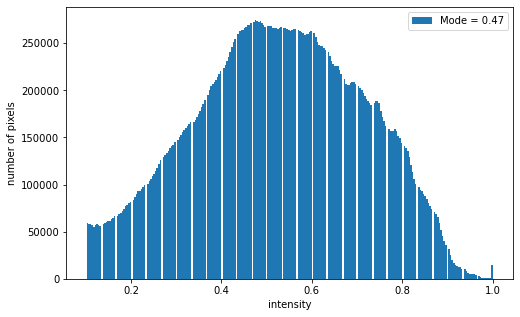

In [13]:
plt.figure(figsize=(8,5))
plt.hist(pneumonia_ap_intensities,bins=256)
mode = stats.mode(pneumonia_ap_intensities)
plt.legend(['Mode = %.2f' % mode[0]])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

These plots show a difference betweeen AP and PA view positions in terms of intensities for both healthy and diseased patients.
Moreover, the mode for pneumonia PA is higher in intensity than the mode for healthy PA, whilst the mode for pneumonia AP is lower in intensity than the mode for healthy AP.
This might mean that we should serparate them while training ou AI.

In [53]:
# Gather a few samples for each disease for both ap and pa views
ap_intensities = []
pa_intensities = []
for disease in all_labels:
    tmp_ap, tmp_pa = [], []
    sample_pa = sample_df_pa[sample_df_pa[disease]==1]['path'].sample(10, replace=True)
    sample_ap = sample_df_ap[sample_df_ap[disease]==1]['path'].sample(10, replace=True)
    for i in sample_pa: 
        img = plt.imread(i)
        img_mask = (img > thresh)
        tmp_pa.extend(img[img_mask].tolist())
    for i in sample_ap: 
        img = plt.imread(i)
        img_mask = (img > thresh)
        tmp_ap.extend(img[img_mask].tolist())
    ap_intensities += [tmp_ap]
    pa_intensities += [tmp_pa]

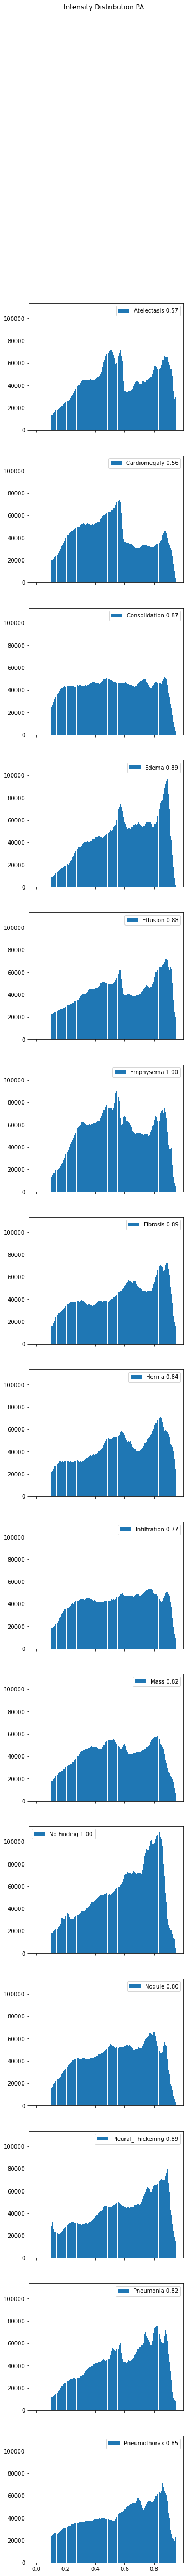

In [58]:
fig2, axs2 = plt.subplots(15, sharex=True, sharey=True)
fig2.suptitle('Intensity Distribution PA')
fig2.set_figheight(75)
fig2.set_figwidth(5)
for i, disease in enumerate(pa_intensities):
    mode = stats.mode(disease)
    axs2[i].hist(disease, bins = 256, range=(0, 0.95))
    axs2[i].legend([all_labels[i] + ' %.2f' % mode[0]])

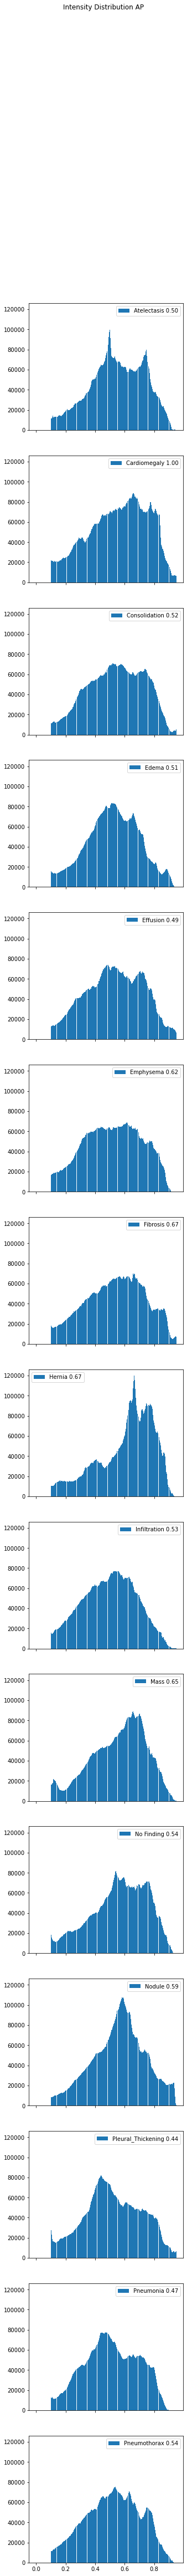

In [57]:
fig, axs = plt.subplots(15, sharex=True, sharey=True)
fig.suptitle('Intensity Distribution AP')
fig.set_figheight(75)
fig.set_figwidth(5)
for i, disease in enumerate(ap_intensities):
    mode = stats.mode(disease)
    axs[i].hist(disease, bins = 256, range=(0, 0.95))
    axs[i].legend([all_labels[i] + ' %.2f' % mode[0]])

Again, we can observe that intenisty distributions differ a lot between PA and AP views.
The modes for Pneumonia seem to be close to the modes of its most common comorbodities, which makes sense, and the distributions seem to differ significantly from the other diseases and from healthy distributions.
This might mean that we could detect pneumonia by mistake when reading images with some of its comobordities, especially effusion so we might remove effusion cases in the dataset.
That being said, we should be able to efficiently distinguish between healthy and abnormal-looking images, which would mean a good (low) amount of false negatives.